In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [2]:
dataset = pd.read_csv("mood_dataset.csv")

X = dataset.drop(columns=['target_mood', 'id', 'date'])

y = dataset['target_mood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))


Random Forest MSE: 0.32269335687934037
Random Forest MAE: 0.3916187140804598


In [4]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])


In [5]:
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [6]:
model = LSTMRegressor(input_dim=X_train.shape[1], hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/20, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 47.3964
Epoch 2/20, Loss: 49.0689
Epoch 3/20, Loss: 46.0200
Epoch 4/20, Loss: 38.9132
Epoch 5/20, Loss: 35.5136
Epoch 6/20, Loss: 31.8306
Epoch 7/20, Loss: 27.5459
Epoch 8/20, Loss: 21.8017
Epoch 9/20, Loss: 21.7289
Epoch 10/20, Loss: 13.8985
Epoch 11/20, Loss: 11.6509
Epoch 12/20, Loss: 9.3756
Epoch 13/20, Loss: 7.2133
Epoch 14/20, Loss: 5.3202
Epoch 15/20, Loss: 3.8916
Epoch 16/20, Loss: 2.4799
Epoch 17/20, Loss: 1.7028
Epoch 18/20, Loss: 1.3359
Epoch 19/20, Loss: 0.7666
Epoch 20/20, Loss: 0.8101


In [7]:
model.eval()
with torch.no_grad():
    y_pred_lstm = model(X_test_torch).squeeze().cpu().tolist()

print("LSTM MSE:", mean_squared_error(y_test, y_pred_lstm))
print("LSTM MAE:", mean_absolute_error(y_test, y_pred_lstm))


LSTM MSE: 1.0939253805117894
LSTM MAE: 0.8245726389446478


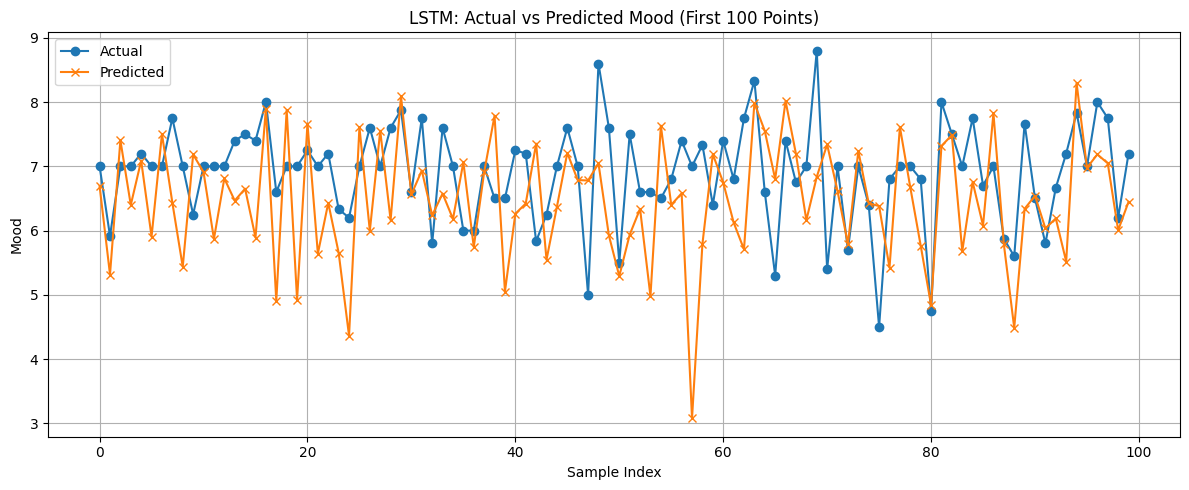

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_lstm[:100], label='Predicted', marker='x')
plt.title("LSTM: Actual vs Predicted Mood (First 100 Points)")
plt.xlabel("Sample Index")
plt.ylabel("Mood")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("LSTM R²:", r2_score(y_test, y_pred_lstm))

Random Forest R²: 0.3632063138901629
LSTM R²: -1.1587205330839176


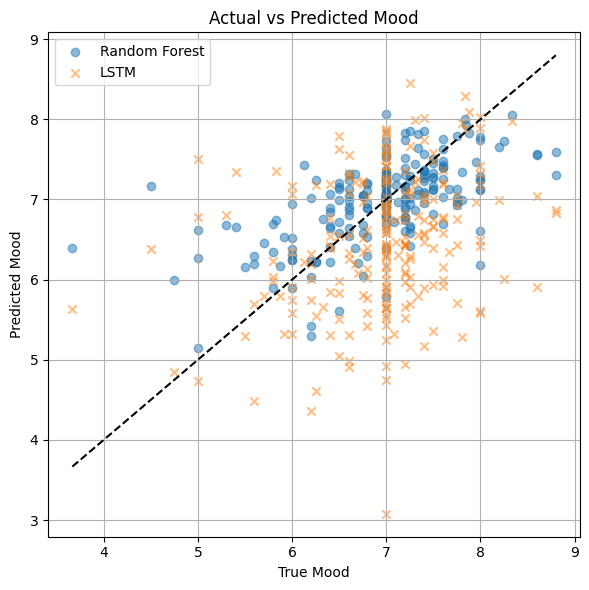

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest', marker='o')
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label='LSTM', marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True Mood")
plt.ylabel("Predicted Mood")
plt.title("Actual vs Predicted Mood")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

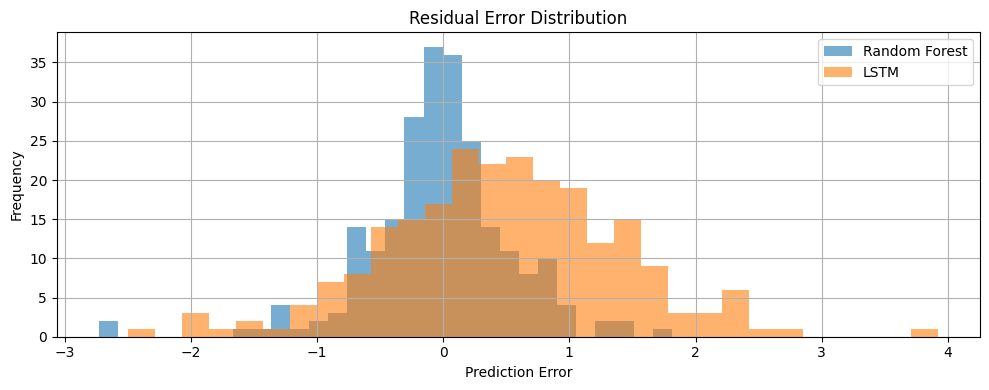

In [11]:
rf_residuals = y_test - y_pred_rf
lstm_residuals = y_test - y_pred_lstm

plt.figure(figsize=(10,4))
plt.hist(rf_residuals, bins=30, alpha=0.6, label='Random Forest')
plt.hist(lstm_residuals, bins=30, alpha=0.6, label='LSTM')
plt.title("Residual Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
